<a href="https://colab.research.google.com/github/audrb1999/ML-DL-Study/blob/main/Pytorch/01_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 작업

- 파이토치에는 데이터 작업을 위해서 



```
# 코드로 형식 지정됨

torch.utils.data.DataLoader
torch.utils.data.Dataset

```
이렇게 두 가지가 존재합니다.

Dataset은 샘플과 정답(label)을 저장하고, DataLoader는 Dataset을 반복 가능한 객체(iterable)로 감쌉니다.

- Daraset은 train set, test set을 만듭니다.
- DataLoader은 mini batch를 만들어주는 역할을 합니다. (dataset을 넣기만 하면 여러 옵션을 통해서 batch를 만듭니다.) 

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets # vision 전용 데이터셋을 제공합니다.
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt 

- Fashion Mnist 데이터를 다운 받는 과정

In [6]:
training_data = datasets.FashionMNIST(
    root = 'data', 
    train=True, download=True, 
    transform = ToTensor())

test_data = datasets.FashionMNIST(
    root='data', 
    train = False, 
    download=True, 
    transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


- 다운 받은 data를 dataloader를 통해서 minibatch로 만듭니다. dataloader에는 batch, sampling, shuffle, multiprocess data loading을 지원합니다.

In [7]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]:", X.shape)
    print("Shape of y:", X.shape)
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64, 1, 28, 28])


In [13]:
len(train_dataloader)

938

In [18]:
len(training_data)/64
# 데이터를 64 미니 배치로 만들어서 길이가 938

937.5

In [20]:
len(train_dataloader.dataset)
# 변형전 데이터 셋을 알려줌

60000

## 모델 만들기

- PyTorch에서는 신경망 모델 nn.Module을 상속받는 클래스를 생성하여 정의합니다. __init_\_으로 신경망 layer을 구성하고 forward 함수에서 신경망의 흐름을 설정합니다. 가능한 경우 GPU로 신경망을 이동시켜 연산을 가속시킵니다.

- CPU에서 GPU로 넘어갈 떄 bottleneck이 존재

super은 상속 관계에서 부모 클래스를 호출하는 함수

super의 인자는 하위 클래스 이름과 하위 클래스 객체가 존재합니다.

In [38]:
# 학습에 사용할 CPU나 GPU 장치를 얻습니다.

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # input size, output size
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NN().to(device)
print(model)


Using cpu device
NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## 모델 매개변수 최적화하기

- loss function과 optimizer을 설정합니다.

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)# 다음과 같이 모델 파라미터를 넣어줌


각 학습 단계에서 모델은 학습 데이터셋에 대한 예측을 수행하고 오차를 역전파하여 학습을 진행합니다.

In [40]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)# 총 데이터 개수
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)# 데이터들을 디바이스에 올리고

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()# zero_grad가 기울기를 계속 초기화해줌
        loss.backward()# 기울기를 구하고
        optimizer.step()# 전달받은 파라미터를 업데이트합니다.

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X) # dict 객체처럼 튜플값을 반납
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

모델의 일반화 성능을 확인하기 위해 테스트 데이터셋으로 모델의 성능을 확인합니다.

In [41]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)# 총 데이터 개수
    num_batches = len(dataloader)#  mini batch 개수
    model.eval()# 평가모드 설정 = batchnorm, dropout, 학습 과정을 없애 속도를 높임
    test_loss, correct = 0, 0 
    with torch.no_grad():# 자동 기울기 계산 꺼짐 = 메모리 사용량 줄임, 속도 증가
        
        # 예측 진행
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches # 평균 loss
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

학습을 진행합니다.

In [42]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300690  [    0/60000]
loss: 2.291497  [ 6400/60000]
loss: 2.280909  [12800/60000]
loss: 2.287650  [19200/60000]
loss: 2.280001  [25600/60000]
loss: 2.252441  [32000/60000]
loss: 2.259251  [38400/60000]
loss: 2.235226  [44800/60000]
loss: 2.247012  [51200/60000]
loss: 2.238177  [57600/60000]
Test Error: 
 Accuracy: 35.3%, Avg loss: 2.241852 

Epoch 2
-------------------------------
loss: 2.228545  [    0/60000]
loss: 2.233551  [ 6400/60000]
loss: 2.201591  [12800/60000]
loss: 2.237141  [19200/60000]
loss: 2.210513  [25600/60000]
loss: 2.155831  [32000/60000]
loss: 2.179818  [38400/60000]
loss: 2.129543  [44800/60000]
loss: 2.169888  [51200/60000]
loss: 2.147395  [57600/60000]
Test Error: 
 Accuracy: 35.1%, Avg loss: 2.160818 

Epoch 3
-------------------------------
loss: 2.133652  [    0/60000]
loss: 2.145888  [ 6400/60000]
loss: 2.084167  [12800/60000]
loss: 2.162921  [19200/60000]
loss: 2.101314  [25600/60000]
loss: 2.016112  [32000/600

## 모델 저장하기

-모델을 저장하는 일반적인 방법은 (모델의 매개변수들을 포함하여) 내부 상태 사전(internal state dictionary)을 직렬화(serialize)하는 것입니다.

In [43]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


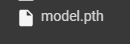

In [48]:
model.state_dict().keys()
# 다음과 같이 가중치들을 사전화해서 저장

odict_keys(['linear_relu_stack.0.weight', 'linear_relu_stack.0.bias', 'linear_relu_stack.2.weight', 'linear_relu_stack.2.bias', 'linear_relu_stack.4.weight', 'linear_relu_stack.4.bias'])

## 모델 불러오기

In [50]:
model = NN()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [51]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
